In [109]:
import pandas as pd
import numpy as np
import requests
import time

from bs4 import BeautifulSoup
from selenium import webdriver
from webdrivermanager.chrome import ChromeDriverManager

ChromeDriverManager.download_and_install
ChromeDriverManager.get_latest_version
driver = webdriver.Chrome(r"C:\Users\TF2020\AppData\Local\rasjani\WebDriverManager\bin\chromedriver.exe")

## Scraping the weather data for the Divvy Bike time series forecasting

In [49]:
all_dates = pd.date_range('2019-09-01','2021-09-1',freq='d').date
def get_url(search):
    url_temp = 'https://www.wunderground.com/dashboard/pws/KILCHICA679/table/{}/{}/daily'
    url = url_temp.format(search, search)
    return url

In [50]:
records = []
missing_date = []
for day in all_dates :
    url = get_url(day)
    driver.get(url) #can switch to requests in order speed up the process



    soup = BeautifulSoup(driver.page_source, 'html.parser')
    try:
        result_parent = soup.find('table', {'class':'history-table desktop-table'})
        results = result_parent.find('tbody')
        
        for row in results.find_all('tr'):
            time_hr = row.find_all('strong',{'_ngcontent-app-root-c152':''})[0].text
            time_hr = pd.to_datetime(time_hr).hour


            record_parent = row.find_all('span',{'class':'wu-value wu-value-to'})
            temperature = float(record_parent[0].text)
            humidity = float(record_parent[2].text)
            wind_speed = float(record_parent[3].text)
            precip = float(record_parent[-2].text)

            uv = int(row.find_all('strong',{'_ngcontent-app-root-c152':''})[-2].text)
            date = pd.to_datetime(day)


            record = (time_hr, temperature, humidity, wind_speed, precip, uv, date)
            records.append(record)

            

    except: 
        missing_date.append(day)

In [51]:
weather_data_raw = pd.DataFrame(records, columns= ['time', 'temperature', 'humidity', 'wind_speed', 'precipation', 'uv', 'date']) #save the data to dataframe
weather_data = weather_data_raw.groupby(['date', 'time'], axis= 0).mean().reset_index(drop= False).round(decimals = 2) #using the mean so we can have the more percise weather data

In [71]:
full_date = pd.DataFrame(pd.date_range('2019-09-01','2021-09-1',freq='h'), columns= ['time']).iloc[:-1,:]

full_date['date'] = pd.to_datetime(full_date['time'].dt.date)
full_date['time'] = full_date['time'].dt.hour
full_date['day_of_week'] = full_date['date'].dt.strftime('%A')


temp = full_date[['date','time']].merge(weather_data, how='left') 
missing_temp = temp[temp.temperature.isnull()][['date','time']]
missing_time = pd.to_datetime(np.unique(missing_temp.date)).date
#the weather sensor will have some missing point, need to try other weather sensor

In [ ]:
def get_url_backup(search):
    url_temp = 'https://www.wunderground.com/dashboard/pws/KILCHICA594/table/{}/{}/daily'
    url = url_temp.format(search, search)
    return url

records = []
missing_date = []

for day in missing_time :
    
    url = get_url_backup(day)
    page_data = requests.get(url).text



    soup = BeautifulSoup(page_data, 'html.parser')
    try:
        result_parent = soup.find('table', {'class':'history-table desktop-table'})
        results = result_parent.find('tbody')
        
        for row in results.find_all('tr'):
            time_hr = row.find_all('strong',{'_ngcontent-app-root-c152':''})[0].text
            time_hr = pd.to_datetime(time_hr).hour


            record_parent = row.find_all('span',{'class':'wu-value wu-value-to'})
            temperature = float(record_parent[0].text)
            humidity = float(record_parent[2].text)
            wind_speed = float(record_parent[3].text)
            precip = float(record_parent[-2].text)

            uv = int(row.find_all('strong',{'_ngcontent-app-root-c152':''})[-2].text)
            date = pd.to_datetime(day)


            record = (time_hr, temperature, humidity, wind_speed, precip, uv, date)
            records.append(record)

            

    except: 
        missing_date.append(day)

In [65]:
missing_data = pd.DataFrame(records, columns= ['time', 'temperature', 'humidity', 'wind_speed', 'precipation', 'uv', 'date'])
missing_data = missing_data.groupby(['date', 'time'], axis= 0).mean().reset_index(drop= False).round(decimals = 2)

In [100]:
temp = missing_temp[['date','time']].merge(missing_data, how='left')

lost_data = temp[temp.temperature.isnull()][['date','time']]
lost_date = pd.to_datetime(np.unique(lost_data.date)).date
len(lost_data) #353 is still too much, finally, for some date, there might be issue of system shut down due to the maintanence.

353

In [130]:
def get_url(search):
    url_temp = 'https://www.wunderground.com/history/daily/KMDW/date/{}' #final choice, use it only when neceessary, hard to clean
    url = url_temp.format(search)
    return url

records = []
missing_date = []
for day in lost_date :
    url = get_url(day)
    driver.get(url)
    time.sleep(2)


    soup = BeautifulSoup(driver.page_source, 'html.parser')
    try:
        result_parent = soup.find('table', {'aria-labelledby':'History observation'})

        results = result_parent.find('tbody')
        for row in results.find_all('tr'):
            time_hr = row.find('span',{'class':'ng-star-inserted'}).text
            time_hr = pd.to_datetime(time_hr).hour

            record_parent = row.find_all('span',{'class':'wu-value wu-value-to'})
            temperature = float(record_parent[0].text)
            humidity = float(record_parent[2].text)
            wind_speed = float(record_parent[3].text)
            precip = float(record_parent[-1].text)
            date = pd.to_datetime(day)
            record = (time_hr, temperature, humidity, wind_speed, precip, date)

            records.append(record)

    except: 
        missing_date.append(day)
        print(day)

In [135]:
missing_data_2 = pd.DataFrame(records, columns= ['time', 'temperature', 'humidity', 'wind_speed', 'precipation', 'date'])
missing_data_2 = missing_data_2.groupby(['date', 'time'], axis= 0).mean().reset_index(drop= False).round(decimals = 2)


In [136]:
#in missing data 2, 11pm are the previous night data, so we need to remove it!
missing_data_2 = missing_data_2[missing_data_2.time != 23]
temp = lost_data[['date','time']].merge(missing_data_2, how='left')
lost_data_2 = temp[temp.temperature.isnull()][['date','time']]

In [138]:
merge_df = full_date[['date','time']].merge(weather_data, how='left') 
merge_df_missing = merge_df[merge_df.temperature.isnull()][['date','time']]
merge_df = merge_df[merge_df.temperature.isnull()==False]

merge_df2 = merge_df_missing.merge(missing_data, how='left')
merge_df2_missing = merge_df2[merge_df2.temperature.isnull()][['date','time']]
merge_df2 = merge_df2[merge_df2.temperature.isnull()==False]

merge_df3 = merge_df2_missing.merge(missing_data_2, how='left')
#combine all the data together!

In [159]:
weather_data_concat = pd.concat([merge_df,merge_df2,merge_df3]).sort_values(by = ['date','time'], ignore_index= True)
#weather_data_concat = weather_data_concat.fillna('missing')

In [160]:
for i in range(len(weather_data_concat)):
    if pd.isna(weather_data_concat.temperature[i]) == True:
        try: #using their nearest record 
            
            weather_data_concat.iloc[i,2:] = weather_data_concat.iloc[i+1,2:]

            if pd.isna(weather_data_concat.temperature[i+1]) == True:

                weather_data_concat.iloc[i,2:] = weather_data_concat.iloc[i+2,2:]
        except:
            weather_data_concat.iloc[i,2:] = weather_data_concat.iloc[i-1,2:]

#for the rest of few missing data, we are using the nearby weather record

In [167]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import seaborn as sns

<AxesSubplot:xlabel='time', ylabel='uv'>

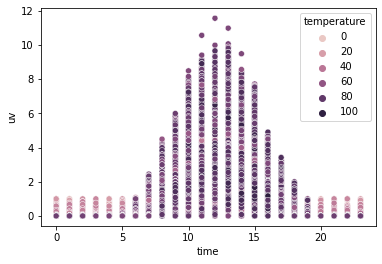

In [175]:
sns.scatterplot(data= weather_data_concat, x = 'time', y='uv', hue='temperature')
#we still have some uv data are missing, but we could use imputer to fit the missing value
#their is a strong relationship between time and the uv level, the imputer will give us a relativly accurate result

In [185]:
imp_mean = IterativeImputer(random_state=0)
imp_mean.fit(weather_data_concat.iloc[:,1:])

complete_data = imp_mean.transform(weather_data_concat.iloc[:,1:])
#IterativeImputer work like a regression model

In [194]:
uv_list = round(pd.DataFrame(complete_data)[5],ndigits=2)
weather_data_concat['uv']=uv_list
#replace the uv value with imputed value

In [196]:
weather_data_concat.to_csv('weather_data.csv', index_label= False) # save the file